# Spaceship Titanic: Feature Selection
## Imports

In [1]:
import warnings
from pathlib import Path
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from IPython.display import display
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
warnings.simplefilter(action="ignore", category=FutureWarning)

## Read data

In [3]:
data_dir = Path.cwd().parent / "input" / "spaceship-titanic"
assert data_dir.exists(), f"directory doesn't exist: {data_dir}"

In [4]:
# Training data (Imputed)
df_train = pd.read_csv(
    data_dir / "train_imputed.csv",
    index_col="PassengerId",
    dtype={"CompCntReduced": pd.CategoricalDtype(categories=["0", "1", "2", "3+"], ordered=True)},
).assign(CompCntReduced=lambda x: x.CompCntReduced.cat.codes)
df_train.head(10)

,Alone,CompCntReduced,HomePlanetOrd,CryoSleep,CabinDeckOrd,CabinPort,DestinationOrd,DiscretizedAge4,DiscretizedAge5,VIP,PosRoomService,PosFoodCourt,PosShoppingMall,PosSpa,PosVRDeck,PTTotalSpent,Transported
PassengerId,,,,,,,,,,,,,,,,,
0001_01,True,0,1,False,0,True,2,3,3,False,False,False,False,False,False,-1.140331,False
0002_01,True,0,0,False,3,False,2,1,2,False,True,True,True,True,True,0.576497,True
0003_01,False,1,1,False,5,False,2,3,4,True,True,True,False,True,True,1.501611,False
0003_02,False,1,1,False,5,False,2,2,3,False,False,True,True,True,True,1.242461,False
0004_01,True,0,0,False,3,False,2,0,0,False,True,True,True,True,True,0.704061,True
0005_01,True,0,0,False,3,True,1,3,4,False,False,True,False,True,False,0.592626,True
0006_01,False,1,0,False,3,False,2,1,2,False,True,True,True,False,False,0.828008,True
0006_02,False,1,0,True,4,False,2,2,2,False,False,False,False,False,False,-1.140331,True
0007_01,True,0,0,False,3,False,2,2,3,False,False,True,True,True,False,0.681374,True


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Alone            8693 non-null   bool   
 1   CompCntReduced   8693 non-null   int8   
 2   HomePlanetOrd    8693 non-null   int64  
 3   CryoSleep        8693 non-null   bool   
 4   CabinDeckOrd     8693 non-null   int64  
 5   CabinPort        8693 non-null   bool   
 6   DestinationOrd   8693 non-null   int64  
 7   DiscretizedAge4  8693 non-null   int64  
 8   DiscretizedAge5  8693 non-null   int64  
 9   VIP              8693 non-null   bool   
 10  PosRoomService   8693 non-null   bool   
 11  PosFoodCourt     8693 non-null   bool   
 12  PosShoppingMall  8693 non-null   bool   
 13  PosSpa           8693 non-null   bool   
 14  PosVRDeck        8693 non-null   bool   
 15  PTTotalSpent     8693 non-null   float64
 16  Transported      8693 non-null   bool   
dtypes: bool(10

In [6]:
assert df_train.isna().sum().eq(0).all()

In [7]:
y_train = df_train.pop("Transported")
X_train = df_train

## Univariate feature selection

Feature selection with chi-square for scoring:

In [8]:
# This makes sense only for categorical variables. This is why `PTTotalSpent`
# is excluded.
selector = SelectKBest(
    chi2,
    k="all",  # pyright: ignore [reportArgumentType]
).fit(X_train.drop(columns="PTTotalSpent"), y_train)
selector = cast(SelectKBest, selector)

In [9]:
# Compute scores
pvalues = cast(npt.ArrayLike, selector.pvalues_)
scores = -np.log10(pvalues)
scores /= scores.max()

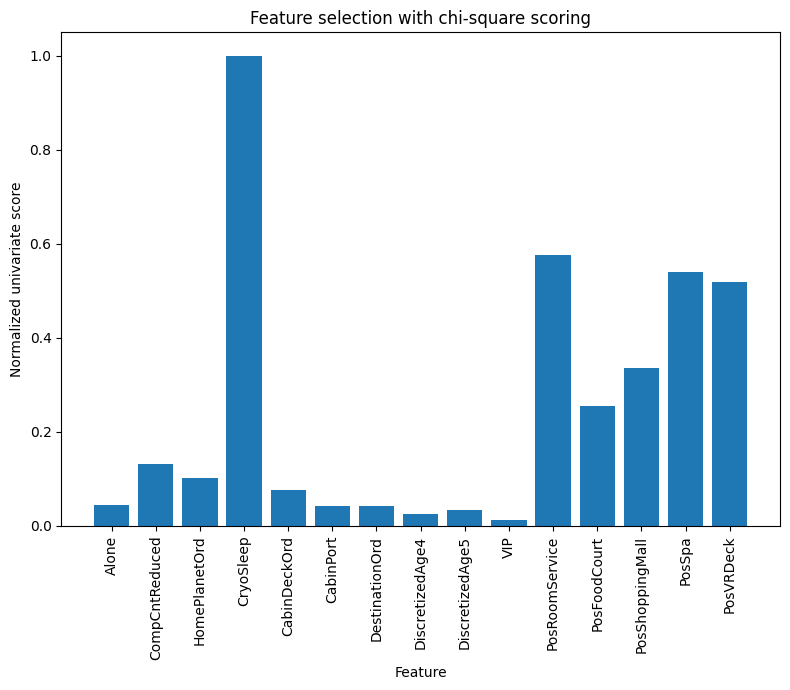

,PValue,Score
Feature,,
Alone,1.290309e-12,0.044846
CompCntReduced,1.620047e-35,0.131229
HomePlanetOrd,1.634373e-27,0.101039
CryoSleep,7.729876e-266,1.000000
CabinDeckOrd,5.339346e-21,0.076468
CabinPort,4.520916e-12,0.042792
DestinationOrd,9.912190e-12,0.041506
DiscretizedAge4,2.563412e-07,0.024862
DiscretizedAge5,1.160803e-09,0.033704


In [10]:
# Visualize results

# Plot scores
fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
x = np.arange(scores.size)
ax.bar(x, scores)
ax.set_xticks(x, labels=selector.feature_names_in_)
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized univariate score")
ax.set_title("Feature selection with chi-square scoring")
plt.show()

# Display scores table
scores_df = pd.DataFrame(
    data={
        "Feature": selector.feature_names_in_,
        "PValue": pvalues,
        "Score": scores,
    }
).set_index("Feature")
display(scores_df)

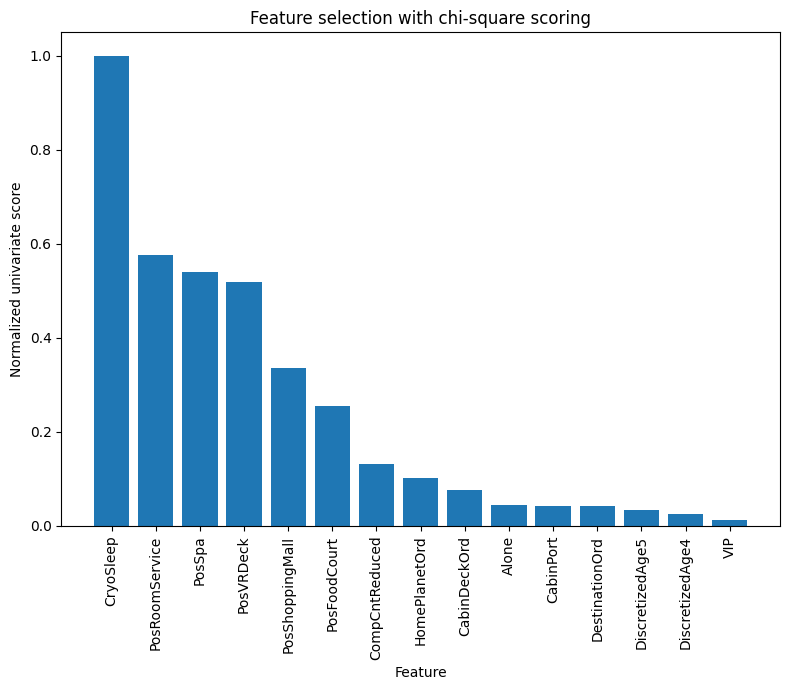

,PValue,Score
Feature,,
CryoSleep,7.729876e-266,1.000000
PosRoomService,1.323365e-153,0.576656
PosSpa,8.771427e-144,0.539610
PosVRDeck,2.173978e-138,0.519263
PosShoppingMall,1.078385e-89,0.335584
PosFoodCourt,1.933636e-68,0.255415
CompCntReduced,1.620047e-35,0.131229
HomePlanetOrd,1.634373e-27,0.101039
CabinDeckOrd,5.339346e-21,0.076468


In [11]:
# Same thing, but order by score
scores_df = scores_df.sort_values(by="Score", ascending=False)

fig = plt.figure(figsize=(8.0, 7.0), layout="tight")
ax = fig.add_subplot()
ax.bar(scores_df.index, scores_df["Score"])
ax.tick_params(axis="x", labelrotation=90.0)
ax.set_xlabel("Feature")
ax.set_ylabel("Normalized univariate score")
ax.set_title("Feature selection with chi-square scoring")
plt.show()

display(scores_df)